In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
from scipy.stats import norm
from tabulate import tabulate
import sqlite3
from sklearn.impute import SimpleImputer

import warnings
warnings.filterwarnings('ignore')

The first step is to load the data from the `listings` table:

In [2]:
data = pd.read_sql_query("SELECT * FROM listings", sqlite3.connect('../data/datawarehouse.db'))

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8628 entries, 0 to 8627
Data columns (total 74 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            8628 non-null   int64  
 1   listing_url                                   8628 non-null   object 
 2   scrape_id                                     8628 non-null   int64  
 3   last_scraped                                  8628 non-null   object 
 4   name                                          8628 non-null   object 
 5   description                                   8628 non-null   object 
 6   neighborhood_overview                         8628 non-null   object 
 7   picture_url                                   8628 non-null   object 
 8   host_id                                       8628 non-null   int64  
 9   host_url                                      8628 non-null   o

There are 8,628 records in the `listings` table. There are missing values in the data although they were filled with N/A.

Let's see a sampling of the data:

In [4]:
data.head()

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,22229408,https://www.airbnb.com/rooms/22229408,20230319041206,2023-03-19,"Explorer's Paradise: Near Train, Bus & Bike Share",Welcome to your perfect urban escape in the Na...,My home is located in the Edgewood neighborhoo...,https://a0.muscache.com/pictures/8e49b7bc-a851...,120875011,https://www.airbnb.com/users/show/120875011,...,4.85,4.75,4.75,,f,1,0,1,0,0.32
1,46951758,https://www.airbnb.com/rooms/46951758,20230319041206,2023-03-19,Boutique Style Home - Rooftop w/Breathtaking V...,Explore or get settled in this artsy modern ro...,"Food & Drinks: Starbucks, Mama's Pizza, Busboy...",https://a0.muscache.com/pictures/miso/Hosting-...,55133178,https://www.airbnb.com/users/show/55133178,...,4.82,4.51,4.8,Hosted License: 5007242201002380\nUnhosted Lic...,f,1,1,0,0,1.87
2,580379638076900630,https://www.airbnb.com/rooms/580379638076900630,20230319041206,2023-03-19,Sojourn | Penthouse | Private Outdoor Space | ...,Boutique building in one of DC's best neighbor...,Dupont Circle stands out as a cosmopolitan jew...,https://a0.muscache.com/pictures/prohost-api/H...,39930655,https://www.airbnb.com/users/show/39930655,...,,,,,f,173,154,13,5,
3,594971943284098653,https://www.airbnb.com/rooms/594971943284098653,20230319041206,2023-03-19,Quaint 1-bedroom apartment with outdoor Patio,Welcome to the center of DC. Half-way between ...,,https://a0.muscache.com/pictures/5746a258-d2f7...,351398058,https://www.airbnb.com/users/show/351398058,...,5.0,4.73,4.73,Hosted License: 5007242201002106\nUnhosted Lic...,t,3,2,1,0,1.2
4,54371126,https://www.airbnb.com/rooms/54371126,20230319041206,2023-03-19,Waterfront Two Bedroom Apartment In a Brand Ne...,Located in Washington in the District of Colum...,,https://a0.muscache.com/pictures/prohost-api/H...,395672427,https://www.airbnb.com/users/show/395672427,...,5.0,5.0,5.0,Unhosted License: 5007242100000024,t,7,7,0,0,0.48


In [5]:
eda_dkn = data.loc[:,["price", "host_response_rate", "host_acceptance_rate"]]
eda_dkn.head()

,price,host_response_rate,host_acceptance_rate
0,$20.00,N/A,N/A
1,$185.00,100%,100%
2,$221.00,99%,100%
3,$142.00,100%,100%
4,$398.00,N/A,N/A


In [6]:
eda_dkn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8628 entries, 0 to 8627
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   price                 8628 non-null   object
 1   host_response_rate    8628 non-null   object
 2   host_acceptance_rate  8628 non-null   object
dtypes: object(3)
memory usage: 202.3+ KB


We then convert categorical variables `price`, `host_response_rate`, and `host_acceptance_rate` into numerical variables.

We first remove `$` and `,` from the column of `price` and `%` from the columns of `host_response_rate` and `host_acceptance_rate`:

In [7]:
eda_dkn['price'] = eda_dkn['price'].str.replace('$', '')
eda_dkn['price'] = eda_dkn['price'].str.replace(',', '')
eda_dkn['host_response_rate'] = eda_dkn['host_response_rate'].str.replace('%', '')
eda_dkn['host_acceptance_rate'] = eda_dkn['host_acceptance_rate'].str.replace('%', '')
eda_dkn.head()

,price,host_response_rate,host_acceptance_rate
0,20.00,N/A,N/A
1,185.00,100,100
2,221.00,99,100
3,142.00,100,100
4,398.00,N/A,N/A


We then look at how many `N/A`s are in these columns:

In [8]:
eda_dkn['price'].str.count('N/A').sum()

0

In [9]:
eda_dkn['host_response_rate'].str.count('N/A').sum()

1473

In [10]:
eda_dkn['host_acceptance_rate'].str.count('N/A').sum()

1073

We then convert `price`, `host_response_rate`, and `host_acceptance_rate` to floats:

In [11]:
eda_dkn['host_response_rate'] = eda_dkn['host_response_rate'].str.replace('N/A', '')
eda_dkn['host_acceptance_rate'] = eda_dkn['host_acceptance_rate'].str.replace('N/A', '')
eda_dkn.head()

,price,host_response_rate,host_acceptance_rate
0,20.00,,
1,185.00,100,100
2,221.00,99,100
3,142.00,100,100
4,398.00,,


In [12]:
for price in eda_dkn.columns:
    eda_dkn[price] = pd.to_numeric(eda_dkn[price], errors='coerce')

eda_dkn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8628 entries, 0 to 8627
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   price                 8628 non-null   float64
 1   host_response_rate    7135 non-null   float64
 2   host_acceptance_rate  7535 non-null   float64
dtypes: float64(3)
memory usage: 202.3 KB


In [13]:
imputer1 = SimpleImputer(strategy='mean', missing_values=np.nan)
imputer1 = imputer1.fit(eda_dkn[['host_response_rate']])
eda_dkn['host_response_rate'] = imputer1.transform(eda_dkn[['host_response_rate']])

imputer2 = imputer1.fit(eda_dkn[['host_acceptance_rate']])
eda_dkn['host_acceptance_rate'] = imputer2.transform(eda_dkn[['host_acceptance_rate']])
eda_dkn.head()

,price,host_response_rate,host_acceptance_rate
0,20.0,96.885774,88.742004
1,185.0,100.000000,100.000000
2,221.0,99.000000,100.000000
3,142.0,100.000000,100.000000
4,398.0,96.885774,88.742004


Now we will add the categorical variable `host_response_time` to the dataframe:

In [14]:
eda_dkn['host_response_time'] = data['host_response_time']
eda_dkn.head()

,price,host_response_rate,host_acceptance_rate,host_response_time
0,20.0,96.885774,88.742004,N/A
1,185.0,100.000000,100.000000,within an hour
2,221.0,99.000000,100.000000,within an hour
3,142.0,100.000000,100.000000,within an hour
4,398.0,96.885774,88.742004,N/A


In [15]:
eda_dkn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8628 entries, 0 to 8627
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   price                 8628 non-null   float64
 1   host_response_rate    8628 non-null   float64
 2   host_acceptance_rate  8628 non-null   float64
 3   host_response_time    8628 non-null   object 
dtypes: float64(3), object(1)
memory usage: 269.8+ KB


Now we will replace missing values in `host_response_time` with the most frequent value:

In [16]:
eda_dkn['host_response_time'] = eda_dkn['host_response_time'].str.replace('N/A', '')
eda_dkn.head()

,price,host_response_rate,host_acceptance_rate,host_response_time
0,20.0,96.885774,88.742004,
1,185.0,100.000000,100.000000,within an hour
2,221.0,99.000000,100.000000,within an hour
3,142.0,100.000000,100.000000,within an hour
4,398.0,96.885774,88.742004,


In [17]:
imputer3 = SimpleImputer(missing_values=None, strategy='constant', fill_value='within an hour')
imputer3 = imputer3.fit(eda_dkn[['host_response_time']])
eda_dkn[['host_response_time']] = imputer3.transform(eda_dkn[['host_response_time']])
eda_dkn.head()

,price,host_response_rate,host_acceptance_rate,host_response_time
0,20.0,96.885774,88.742004,
1,185.0,100.000000,100.000000,within an hour
2,221.0,99.000000,100.000000,within an hour
3,142.0,100.000000,100.000000,within an hour
4,398.0,96.885774,88.742004,


We decided not to fill in the missing values in host_response_time, since it will bring up bias. 
  
Now we will conduct EDA:

### Single Variables 

We will start with the single variable EDA of all features provided in the data. 

#### price

`price` is a numerical variable that measures the rent that the host listed. Let's get a sense of the range of this variable by looking at the summary statistics:

In [18]:
eda_dkn["price"].describe()

count    8628.000000
mean      181.288711
std       224.678136
min         0.000000
25%        85.000000
50%       131.000000
75%       207.000000
max      7500.000000
Name: price, dtype: float64

The variable is definitely skewed right. The mean is 181.3 and the median is 131.0. The 1st quartile is85 while the 3rd quartile is 207. Let's plot a histogram of the data using Freeman Diaconis bins: 

In [19]:
def freeman_diaconis( data):
    quartiles = stats.mstats.mquantiles( data, [0.25, 0.5, 0.75])
    iqr = quartiles[2] - quartiles[ 0]
    n = len( data)
    h = 2.0 * (iqr/n**(1.0/3.0))
    return int( h)

Freeman Diaconis:  11


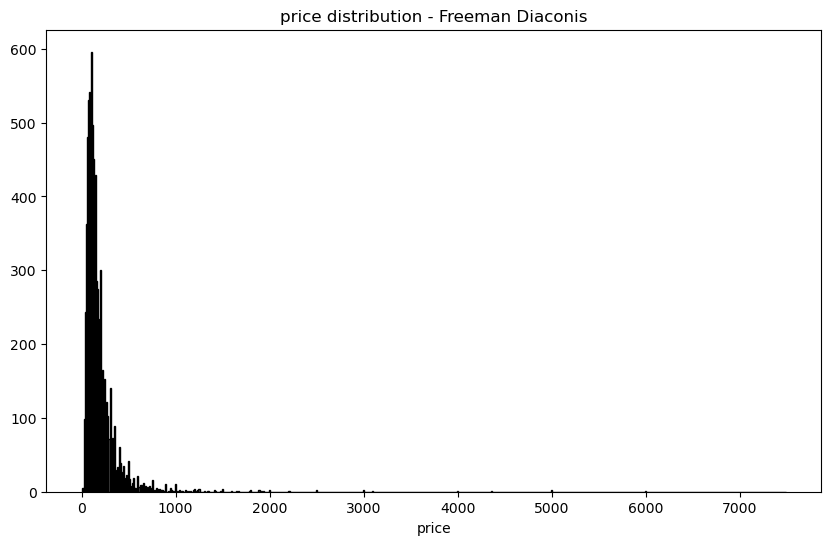

In [20]:
h = freeman_diaconis(eda_dkn["price"])
print("Freeman Diaconis: ", h)
mn = int(eda_dkn["price"].min())
mx = int(eda_dkn["price"].max())
bins = [i for i in range( mn, mx, h)]

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(eda_dkn["price"],bins=bins, histtype='bar', color="DimGray", ec='black')
axes.set_title("price distribution - Freeman Diaconis")
axes.set_xlabel("price")

plt.show()
plt.close()

The distribution of the data is skewed right. This suggests that in this database, the price of the Airbnb is mostly at the lower end which is cheaper. And it created this skewness. 

<a href="#EDA">^ EDA</a>

#### host_response_time

`host_response_time` is a categorical variable. More specifically, it is a variable that takes values of a few days or more, within a day, within a few hours, and within an hour. We can get a distribution of its values using `value_counts()`:

In [21]:
eda_dkn["host_response_time"].value_counts().sort_index()

                      1493
a few days or more      91
within a day           562
within a few hours    1099
within an hour        5383
Name: host_response_time, dtype: int64

Interestingly, the dataset has the highest number of within an hour, the second highest number of within a few hours, the 3rd highest number of with a day and the lowest as a few days or more. This suggests that the host tends to respond quickly in order to rent out their houses.

#### host_response_rate

`host_response_rate` is a numerical variable that measures the percentages that the host will respond. We would expect that the price of the Airbnb will increase with the increase of the host_response_rate. Let's get a sense of the range of this variable by looking at the summary statistics:

In [22]:
eda_dkn["host_response_rate"].describe()

count    8628.000000
mean       96.885774
std        10.176818
min         0.000000
25%        96.885774
50%       100.000000
75%       100.000000
max       100.000000
Name: host_response_rate, dtype: float64

The minimum `host_response_rate` is 0 which means that the host never responded and the maximum is 100%. This is a big range which tells me that the variable is definitely skewed. The mean is 96.9 and the median is 100 which suggests a left skewness. Recall that when the mean < median, this suggest a left- skewed distribution. Let's plot a histogram of the data using Freeman Diaconis bins. The use of Freeman Diaconis bins allows us to select the width of the bins to be used in a histogram. 

In [23]:
h1 = freeman_diaconis(eda_dkn.host_response_rate)
print("Freeman Diaconis: ", h1)

Freeman Diaconis:  0


Since the Freeman Diaconis width of bins is 0, we can not use it to make a histogram. Instead, we will use a different number for the bin sizes to look at the histograms of Rings data.

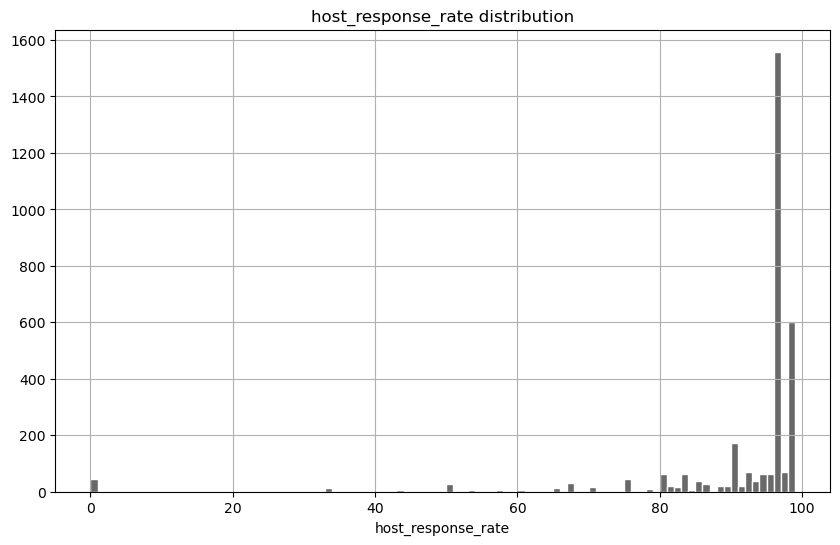

In [24]:
# Ref: Fundamentals
mn = int(eda_dkn.host_response_rate.min())
mx = int(eda_dkn.host_response_rate.max())
bins = [i for i in range( mn, mx, 1)]

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(eda_dkn.host_response_rate,bins=bins, color="DimGray", edgecolor = "white")
axes.set_title("host_response_rate distribution")
axes.set_xlabel("host_response_rate")
axes.grid()

plt.show()
plt.close()

The distribution of the data looks very much skewed left which makes some sense given if the host responds more, the price will go up.

<a href="#EDA">^ EDA</a>

#### host_acceptance_rate

`host_acceptance_rate` is a numerical variable that measures percentages of host accepts the requests. Similarly, we should expect that the price would go up with the increase of the host_acceptance_rate. Let's get a sense of the range of this variable by looking at the summary statistics:

In [25]:
eda_dkn["host_acceptance_rate"].describe()

count    8628.000000
mean       88.742004
std        18.887827
min         0.000000
25%        88.742004
50%        97.000000
75%       100.000000
max       100.000000
Name: host_acceptance_rate, dtype: float64

The variable is definitely skewed left. The mean is 88.7% and the median is 97.0%. The 1st quartile is the same as the mean while the 3rd quartile is 100%. Let's plot a histogram of the data using Freeman Diaconis bins: 

Freeman Diaconis:  1


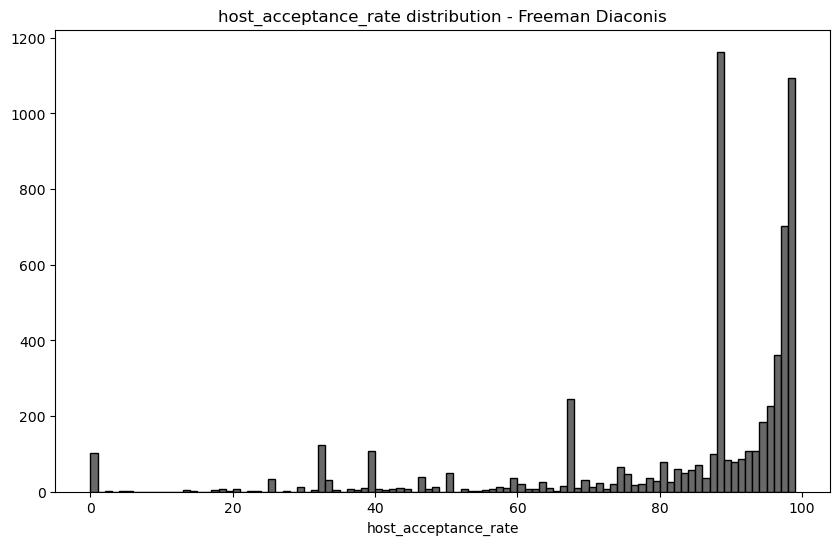

In [26]:
h = freeman_diaconis(eda_dkn["host_acceptance_rate"])
print("Freeman Diaconis: ", h)
mn = int(eda_dkn["host_acceptance_rate"].min())
mx = int(eda_dkn["host_acceptance_rate"].max())
bins = [i for i in range( mn, mx, h)]

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(eda_dkn["host_acceptance_rate"],bins=bins, histtype='bar', color="DimGray", ec='black')
axes.set_title("host_acceptance_rate distribution - Freeman Diaconis")
axes.set_xlabel("host_acceptance_rate")

plt.show()
plt.close()

The distribution of the data is skewed left. Similarly, if we assume that the price will depend on the increase of host_acceptance_rate, it created this skewness. 

<a href="#EDA">^ EDA</a>

### Pairwise Variable EDA

Given our guidance, we'll look at these 3 variables in relation to `price`. Along the way, questions may be suggested and answered within. In addition, the following are some helper functions for our EDA problem. 

<a href="#EDA">^ EDA</a>

In [27]:
def classify_correlation(r):
    r = abs(r)
    if r < 0.16:
        return "very weak"
    if r < 0.29:
        return "weak"
    if r < 0.49:
        return "low"
    if r < 0.69:
        return "moderate"
    if r < 0.89:
        return "strong"
    return "very strong"

In [28]:
def correlation(data, x, y):
    print("Correlation coefficients:")
    r = stats.pearsonr(data[x], data[y])[0]
    print( "r   =", r, f"({classify_correlation(r)})")
    rho = stats.spearmanr(data[x], data[y])[0]
    print( "rho =", rho, f"({classify_correlation(rho)})")

In [29]:
def describe_by_category(data, numeric, categorical, transpose=False):
    grouped = data.groupby(categorical)
    grouped_y = grouped[numeric].describe()
    if transpose:
        print(grouped_y.transpose())
    else:
        print(grouped_y)

In [30]:
def lowess_scatter(data, x, y, jitter=0.0, skip_lowess=False):

    if skip_lowess:
        fit = np.polyfit(data[x], data[y], 1)
        line_x = np.linspace(data[x].min(), data[x].max(), 10)
        line = np.poly1d(fit)
        line_y = list(map(line, line_x))
    else:
        lowess = sm.nonparametric.lowess(data[y], data[x], frac=.3)
        line_x = list(zip(*lowess))[0]
        line_y = list(zip(*lowess))[1]

    figure = plt.figure(figsize=(10, 6))

    axes = figure.add_subplot(1, 1, 1)

    xs = data[x]
    if jitter > 0.0:
        xs = data[x] + stats.norm.rvs( 0, 0.5, data[x].size)

    axes.scatter(xs, data[y], marker="o", color="DimGray", alpha=0.5)
    axes.plot(line_x, line_y, color="DarkRed")

    title = "Plot of {0} v. {1}".format(x, y)
    if not skip_lowess:
        title += " with LOWESS"
    axes.set_title(title)
    axes.set_xlabel(x)
    axes.set_ylabel(y)

    plt.show()
    plt.close()

As we have just seen, the price data has a very normal distribution with right (positive) skewness on it. Generally, this is a result of the mixture of processes that are creating distinct subgroups or population in the data. The question is where we can identify these subgroups using the data we have.

#### price vs host_response_rate

We can definitely expect to see the higher the host_response_rate, the higher the price is. Since this pairwise comparison is between two numerical variables, we can start by seeing the correlation of the two variables. 

In [31]:
correlation(eda_dkn, "host_response_rate", "price")

Correlation coefficients:
r   = 0.0034642167787886885 (very weak)
rho = 0.03179421676325014 (very weak)


Pearson's correlation coefficient, $r$, is only 0.003 which indicates a very weak positive relationship. Spearman's is at 0.032 which might indicate a very weak monotonic relationship. Let's plot the data using Lowess. That is by using locally weighted smoothing (LOWESS), this method of regression analysis creates a smooth line through a scatterplot in order to see the trend between both variables. 

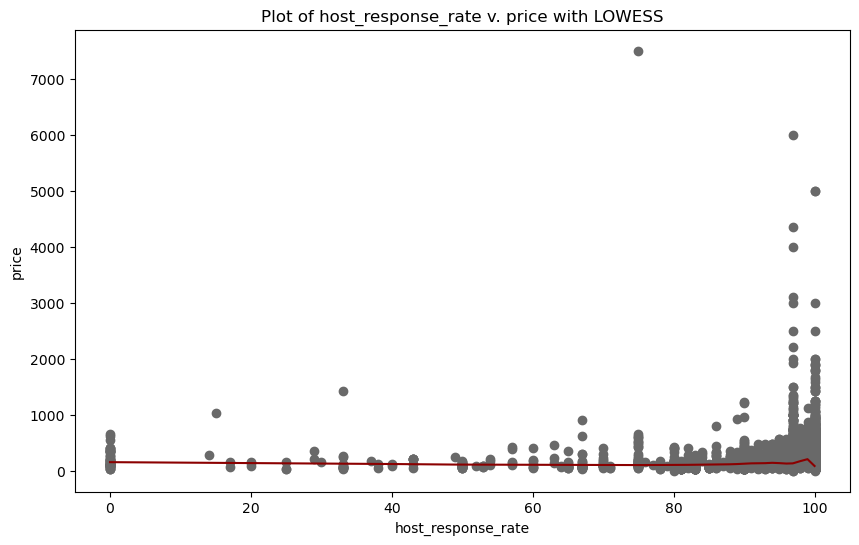

In [32]:
import statsmodels.api as sm

lowess = sm.nonparametric.lowess(eda_dkn["price"], eda_dkn["host_response_rate"], frac=.3)
lowess_x = list(zip(*lowess))[0]
lowess_y = list(zip(*lowess))[1]

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter( eda_dkn["host_response_rate"], eda_dkn["price"], marker="o", color="DimGray")
axes.plot(lowess_x, lowess_y, color="DarkRed")

axes.set_title("Plot of host_response_rate v. price with LOWESS")
axes.set_xlabel( "host_response_rate")
axes.set_ylabel( "price")

plt.show()
plt.close()

Through this scatterplot and the lowess line, we can see that there is a very weak postive linear relationship between host_response_rate and price. 

#### price vs host_acceptance_rate

We can expect to see the higher the host_acceptance_rate, the higher the price is. Since this pairwise comparison is between two numerical variables, we can start by seeing the correlation of the two variables. 

In [33]:
correlation(eda_dkn, "host_acceptance_rate", "price")

Correlation coefficients:
r   = 0.08805895808423946 (very weak)
rho = 0.14416708640135498 (very weak)


Pearson's correlation coefficient, $r$, is only 0.088 which indicates a very weak positive relationship. Spearman's is at 0.144 which might indicate a very weak monotonic relationship. Let's plot the data using Lowess. That is by using locally weighted smoothing (LOWESS), this method of regression analysis creates a smooth line through a scatterplot in order to see the trend between both variables. 

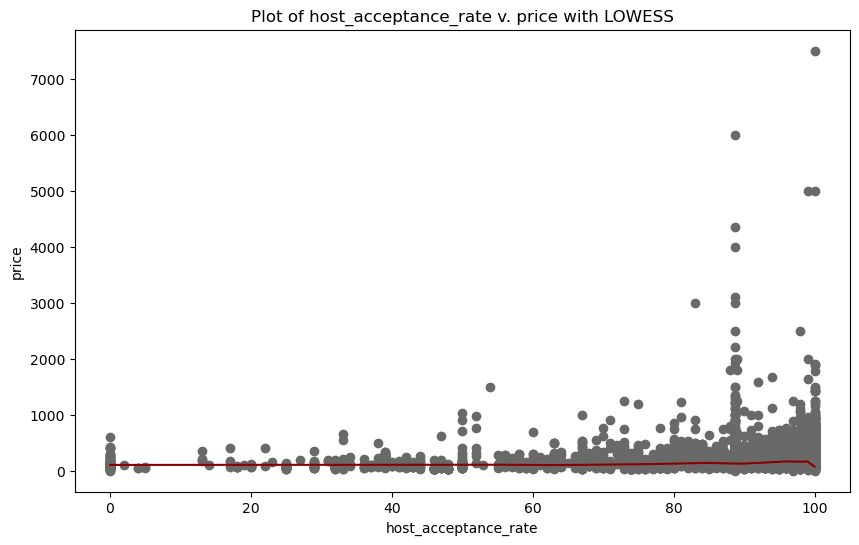

In [34]:
import statsmodels.api as sm

lowess = sm.nonparametric.lowess(eda_dkn["price"], eda_dkn["host_acceptance_rate"], frac=.3)
lowess_x = list(zip(*lowess))[0]
lowess_y = list(zip(*lowess))[1]

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter( eda_dkn["host_acceptance_rate"], eda_dkn["price"], marker="o", color="DimGray")
axes.plot(lowess_x, lowess_y, color="DarkRed")

axes.set_title("Plot of host_acceptance_rate v. price with LOWESS")
axes.set_xlabel( "host_acceptance_rate")
axes.set_ylabel( "price")

plt.show()
plt.close()

Through this scatterplot and the lowess line, we can see that there is a very weak postive linear relationship between host_response_rate and price. 

#### price vs host_reponse_time

It is possible that the host_response_time has a negative correlation with the price since when the not hearing from the host, most people just start to look for a new ad. Because this pairwise correlation is marked by a categorical variable and a numerical variable, using summary statistics in relation to each other gives us the perspective we are looking for:

In [35]:
describe_by_category(eda_dkn, "price", "host_reponse_time", transpose=True)

KeyError: 'host_reponse_time'